In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## ram
import gzip
import gc #garbage collector

# Surprise
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate

In [6]:
## function para leer cada linea de los datos comprimidos
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [7]:
#### Importar los datos de las caracteristicas de los juegos

## Funcion que da acamica para abrir solo cada cierta cantidad de datos.
'''
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1
'''
## Funcion para coger solo una cantidad de datos en orden
data_games = []
num = 100000
for i, l in enumerate(parse('datos\steam_games.json.gz')):
    data_games.append(l)
    if i == num:
        break

In [8]:
#### Importar los datos de las reviews

## Funcion que da acamica para abrir solo cada cierta cantidad de datos.
'''
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1
'''
## Funcion para coger solo una cantidad de datos en orden
data_reviews = []
num = 100000
for i, l in enumerate(parse('datos\steam_reviews.json.gz')):
    data_reviews.append(l)
    if i == num:
        break

In [9]:
## Crear un data frame con los datos
df_games = pd.DataFrame(data_games)
df_rev = pd.DataFrame(data_reviews)
# df_rev.head()
# df_games.head()

# Analisis exploratorio de datos

In [10]:
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   username      100001 non-null  object 
 1   hours         99854 non-null   float64
 2   products      99854 non-null   float64
 3   product_id    100001 non-null  object 
 4   page_order    100001 non-null  int64  
 5   date          100001 non-null  object 
 6   text          100001 non-null  object 
 7   early_access  100001 non-null  bool   
 8   page          100001 non-null  int64  
 9   found_funny   17263 non-null   float64
 10  compensation  2523 non-null    object 
 11  user_id       39258 non-null   object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 8.5+ MB


## Analisis de datos de info games
- Se ve que las variables de discount_price y las de metascore faltan mucho
- Se observa que esta la feature "sentiment" que nos dice el rating general de el juego
- El nombre del juego es la feature 'title' pero tambien "app name" se puede usar como substituto
- los atributos generos y tags son muy parecidos entre si, solo que genero es solamente tiene los generos de los juegos, pero por esta razon tiene mas naans que tags
- Hay caracteres no occidentales y emojis asi que hay que tener cuidado con los errores de encoding

In [11]:
df_rev.info()
df_rev.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   username      100001 non-null  object 
 1   hours         99854 non-null   float64
 2   products      99854 non-null   float64
 3   product_id    100001 non-null  object 
 4   page_order    100001 non-null  int64  
 5   date          100001 non-null  object 
 6   text          100001 non-null  object 
 7   early_access  100001 non-null  bool   
 8   page          100001 non-null  int64  
 9   found_funny   17263 non-null   float64
 10  compensation  2523 non-null    object 
 11  user_id       39258 non-null   object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 8.5+ MB


,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075


In [12]:
len(df_rev[df_rev.duplicated(subset=['username'],keep=False)])

23665

# Analisis de Features datos de review
- hay que usar los datos de username para identificar a los usuarios (creo que los nombres son unicos). Hay que ver de alguna manera si dos personas pueden tener el mismo username.
- El 2.7 porciento del dataset es de personas que hacen varias reviews (Hacer graficos con el numero de reviews que hace una persona)
- La feature "text" puede servir para hacer un analisis de sentimiento
- El numero de horas jugadas puede encodearse para utilizarlo como un suplente de rating

# Graficos
- Coger mas datos a la manera de acamica. 
Para hacer estos graficos necesitamos una dataset mas grande y representativo. Tendremos que usar la funcion que lee una row del dataset cada cierto numero de lines(la funcion que nos da acamica) para evitar solo coger datos de cierto tipo de juegos. Como las reviews estan en un orden, al usar la funcion de datos podriamo accidentalmente, y si las suerte no nos acompaña, escoger un tipo de juego que no represente la totalidad de los juegos, por ejemplog, que en los 1000 datos ordenas cojamos solo los juegod free-to-play, o los juegos indies, que posiblemente tengan reviews mas bajas que otros..


- Hacer un grafico de las horas jugadas del juego #todo
- Hacer un grafico de el numero de reviews que hace la gente #todo

## PARA HACER
- Podemos usar el target como la combinacion de el numero de horas jugadas combinado con el analisis de sentimiento de la review. (primero hacer con el encoding ) #todo

In [27]:
### borrar los nan en horas jugadas
#df_rev.hours.isna().sum()
df_rev.dropna(subset=['hours'], inplace=True)

In [28]:
df_rev.hours.isna().sum()

0

(0.0, 100.0)

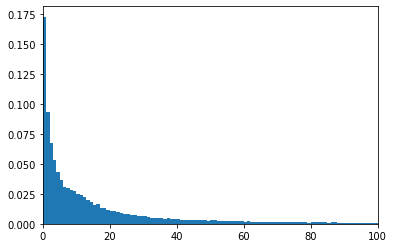

In [29]:
#### encoding de datos
df_rev.hours
plt.hist(x=df_rev.hours, bins=100, density=True, range=(0,100))
plt.xlim([0,100])

(0.0, 50.0)

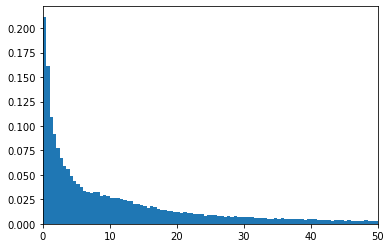

In [30]:
plt.hist(x=df_rev.hours, bins=100, density=True, range=(0,50))
plt.xlim([0,50])

In [31]:
## lo que tenemos aqui es sin duda una power law que vamos a encodear
## de una manera especial.
## normalizar con log
df_rev['log_hours'] = np.log(df_rev.hours)

C:\Users\andre\.conda\envs\data2\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-10.0, 10.0)

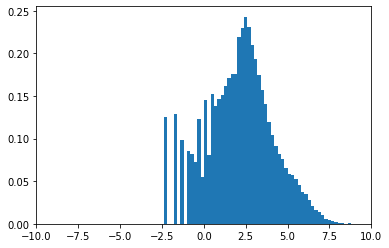

In [32]:
## escalado logaritmico
plt.hist(x=df_rev.log_hours, bins=100, density=True, range=(-10,10))
plt.xlim([-10,10])

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,10))
dataset = scaler.fit_transform(np.asarray(df_rev.log_hours).reshape(-1, 1))

In [34]:
df_rev['escalados'] = dataset

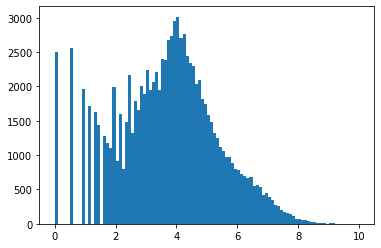

In [35]:
# quedan raros los datos
plt.hist(x=df_rev.escalados, bins=100)
plt.show()

In [99]:
#### meterlos al surprise
# from surprise import Reader, Dataset, SVD, accuracy
# from surprise.model_selection import cross_validate
# columnas user; item; rating; timestamp
# dataset  username; product_id; escalado; date
df_reader = df_rev[['username', 'product_id', 'escalados']] #date lacking
df_reader.dropna(inplace=True)

C:\Users\andre\.conda\envs\data2\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [100]:
array = df_reader.username.astype(str)

In [101]:
### encoding the names
from sklearn.preprocessing import OrdinalEncoder

le = OrdinalEncoder()
users = le.fit_transform(np.asarray(array).reshape(-1, 1))
users = users.astype(int)
df_reader.insert(0,'user', users)

In [103]:
df_reader = df_reader.drop(columns=['username'])
df_reader

,user,product_id,escalados
0,9915,725280,0.000000
1,83213,328100,5.195230
2,70080,328100,4.151611
3,12199,35140,3.258925
4,13355,35140,4.258560
...,...,...,...
99996,34394,291550,4.619430
99997,46184,291550,6.404132
99998,5953,291550,4.233082
99999,34931,233270,2.136740


In [104]:
reader = Reader(rating_scale=(1,10), line_format='user item rating')
data = Dataset.load_from_df(df_reader, reader=reader)

In [105]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25)

In [107]:
algo = SVD()
# Train the algorithm on the trainset, and predict ratings for the testset
# algo.fit(trainset)
# predictions = algo.test(testset)

# Then compute RMSE
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2488  1.2604  1.2339  1.2497  1.2410  1.2468  0.0089  
MAE (testset)     0.9279  0.9377  0.9187  0.9302  0.9243  0.9277  0.0063  
Fit time          4.99    4.89    4.94    4.89    4.87    4.91    0.04    
Test time         0.11    0.11    0.11    0.29    0.11    0.15    0.07    


{'test_rmse': array([1.24882953, 1.26044983, 1.23387344, 1.24971265, 1.24101763]),
 'test_mae': array([0.92788791, 0.93766794, 0.91873183, 0.93018529, 0.92426111]),
 'fit_time': (4.986541032791138,
  4.890384912490845,
  4.939109563827515,
  4.886096477508545,
  4.865110397338867),
 'test_time': (0.11059021949768066,
  0.11102437973022461,
  0.1090238094329834,
  0.2850642204284668,
  0.11022543907165527)}

In [108]:
algo = SVD()
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

In [111]:
predictions[2]

Prediction(uid=64039, iid='310370', r_ui=1.1548574711035533, est=1.1353366142866363, details={'was_impossible': False})

In [112]:
algo.predict(9915, 35140)

Prediction(uid=9915, iid=35140, r_ui=None, est=3.669855386626867, details={'was_impossible': False})